In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pymc3 as pm

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


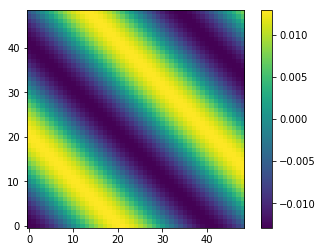

In [3]:
#Seismic displacement in two-dimensions

#First define constants for the model
rho0 = 1800 #Density of the homogeneous medium in kg/m^3, as taken from Beker's thesis paper, pg. 84
alpha = 0.31 #Parameter used in Beker's paper to determine primary wave speed pg. 84
beta = 0.25 #Parameter used in Beker's paper to determine primary wave speed pg 84.
nu = 0.25 #Poisson ratio as taken from Beker's thesis paper pg. 84

CP = ((rho0/1000) / alpha)**(1.0 / beta) #Calculating primary wave speed using equation from Beker's paper, pg. 84
CS = np.sqrt((1-2*nu)/(2-2*nu)) * CP #Calculating secondary wave speed using equation from Beker's paper, pg. 84
Root = np.roots([1, -8, 8 * ((2 - nu)/(1 - nu)), -8 / (1 - nu)]) #Calculating the the ratio of the R wave speed to the p wave speed squared using equation found in Harm's and Beker's paper, pg. 20 in Beker's paper
for i in Root:
    if 0<i<1:
        CR = np.sqrt(CS**2 *i) #calculating R wave speed

x1_list = np.linspace(0,500, 49) #x-positions to be evaluated
y1_list = np.linspace(0, 500, 49) #y-positions to be evaluated
t1_list = np.linspace(0, 6, 100) #time interval to be evaluated

def xi_horiz(x, y, z, t, f, theta, phi): 
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    return (ke * np.exp(q_z_p * z) - zeta * np.exp(q_z_s * z)) * np.sin(np.dot(ke_vec, [x,y]) - omega * t + phi)

def xi_vert(x, y, z, t, f, theta, phi):
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    return (q_z_p * np.exp(q_z_p * z) - zeta * ke * np.exp(q_z_s * z)) * np.cos(np.dot(ke_vec, [x,y]) - omega * t + phi)

H = np.zeros((len(x1_list), len(y1_list)))
for j, yn in enumerate(y1_list):
    for i, xn in enumerate(x1_list):
        H[i,j] = xi_vert(xn, yn, 0, 0, 2, np.pi /4, 0)
        
fig3 = plt.imshow(H, cmap='viridis', origin='lower')
plt.colorbar()

In [8]:
#Seismic Newtonian Noise due to two-dimensional Rayleigh wave

G = 6.67e-11 #Newton's constant of gravity
rho_0 = 1800 #density of the medium in kg/m^3

def xi(xn, yn, zn, t, f, theta, phi):
    return [np.cos(theta) * xi_horiz(xn, yn, zn, t, f, theta, phi), np.sin(theta) * xi_horiz(xn, yn, zn, t, f, theta, phi)] #defining horizontal displacement vector

xi_field_horiz = np.zeros((len(x1_list), len(y1_list))) #array of points the seismic displacement will be calculated at
xi_field_vert = np.zeros((len(x1_list), len(y1_list)))
V = (500 * 500 *3) / (len(x1_list) * len(y1_list)) #Giving each element equal volume that sums to the volume of the entire field

def seis_NN(z, t, f, theta, phi, x0, y0):
    for i, xn in enumerate(x1_list):
        for j, yn in enumerate(y1_list):
            if xn == x0 and yn == y0:
                xi_field_horiz[i,j] =  0
                xi_field_vert[i,j] = 0
            elif xn <= CR * np.cos(theta) * t and yn <= np.sin(theta) * CR * t: #only points the wave has reached will be displaced
                r_i = [xn - x0, yn - y0] #vector from point of displacement to test mass
                r_i_magn = np.linalg.norm(r_i) #magnitude of r_i 
                r_i_hat = r_i / r_i_magn #unit vector in r_i direction
                xi_field_horiz[i, j] = V * G * rho_0 * (1 / r_i_magn**3) * np.linalg.norm((np.array(xi(xn, yn, z, t, f, theta, phi)) - 3 * np.dot(r_i_hat, xi(xn, yn, z, t, f, theta, phi)) * np.array(r_i_hat)))
                xi_field_vert[i ,j] = G * rho_0 * (1/r_i_magn**3) * xi_vert(xn, yn, z, t, f, theta, phi)
            else:
                xi_field_horiz[i, j] = 0
                xi_field_vert[i, j] = 0
    seis_nn_horiz = np.sum(xi_field_horiz) #summing the contributions from each point in the grid 
    seis_nn_vert = np.sum(xi_field_vert)
    seis_nn_total = np.vstack((seis_nn_horiz, seis_nn_vert))
    total_seis_nn = np.linalg.norm(seis_nn_total) #calculating the total noise from vertical and horizontal displacement
    return total_seis_nn

T_1 = np.zeros(len(t1_list))
for i, tn in enumerate(t1_list):
    T_1[i] = seis_NN(0, tn, 2, np.pi/4, 0, 250, 250)

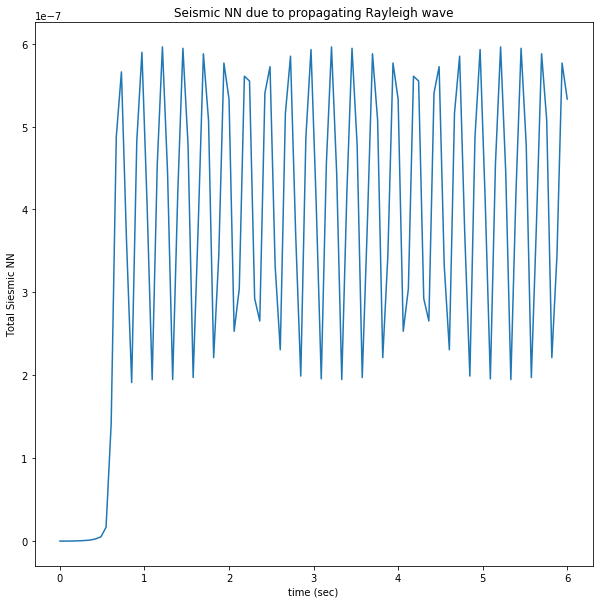

In [9]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, xlabel='time (sec)', ylabel='Total Siesmic NN', title='Seismic NN due to propagating Rayleigh wave')
ax1.plot(t1_list, T_1)

In [13]:
#Seismic Newtonian Noise due to two-dimensional impulse of Rayleigh wave

G = 6.67e-11 #Newton's constant of gravity
rho_0 = 1800 #density of the medium in kg/m^3
V = 1 #volume of each element

def xi(xn, yn, zn, t, f, theta, phi):
    return [np.cos(theta) * xi_horiz(xn, yn, zn, t, f, theta, phi), np.sin(theta) * xi_horiz(xn, yn, zn, t, f, theta, phi)] #defining horizontal displacement vector

xi_field_horiz = np.zeros((len(x1_list), len(y1_list))) #array of points the seismic displacement will be calculated at
xi_field_vert = np.zeros((len(x1_list), len(y1_list)))
def seis_NN(z, t, f, theta, phi, x0, y0):
    for i, xn in enumerate(x1_list):
        for j, yn in enumerate(y1_list):
            if (CR * t - 353.05) * np.cos(theta) <= xn <= CR * np.cos(theta) * t and (CR * t - 353.05) * np.sin(theta) <= yn <= np.sin(theta) * CR * t: #only points the wave has reached will be displaced
                r_i = [xn - x0, yn - y0] #vector from point of displacement to test mass
                r_i_magn = np.linalg.norm(r_i) #magnitude of r_i 
                r_i_hat = r_i / r_i_magn #unit vector in r_i direction
                xi_field_horiz[i, j] = G * rho_0 * (1 / r_i_magn**3) * np.linalg.norm((np.array(xi(xn, yn, z, t, f, theta, phi)) - 3 * np.dot(r_i_hat, xi(xn, yn, z, t, f, theta, phi)) * np.array(r_i_hat)))
                xi_field_vert[i ,j] = G * rho_0 * (1/r_i_magn**3) * xi_vert(xn, yn, z, t, f, theta, phi)
            else:
                xi_field_horiz[i, j] = 0
                xi_field_vert[i, j] = 0
    seis_nn_horiz = np.sum(xi_field_horiz) #summing the contributions from each point in the grid 
    seis_nn_vert = np.sum(xi_field_vert)
    seis_nn_total = np.vstack((seis_nn_horiz, seis_nn_vert))
    total_seis_nn = np.linalg.norm(seis_nn_total) #calculating the total noise from vertical and horizontal displacement
    return total_seis_nn

T_1 = np.zeros(len(t1_list))
for i, tn in enumerate(t1_list):
    T_1[i] = seis_NN(0, tn, 2, np.pi/4, 0, 251, 251)

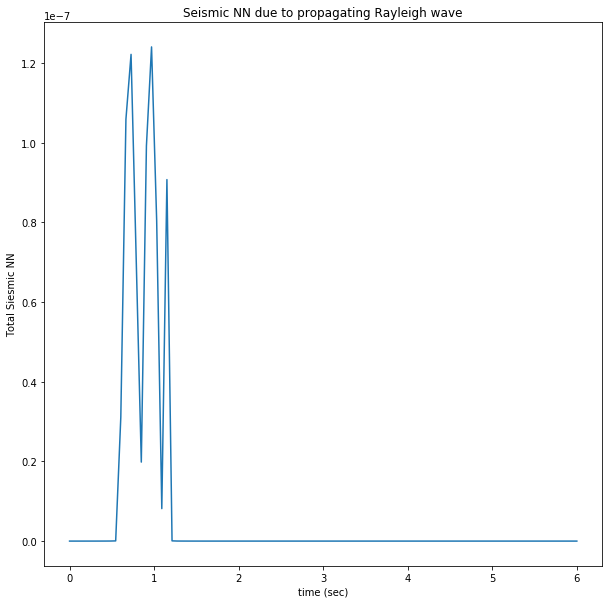

In [14]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, xlabel='time (sec)', ylabel='Total Siesmic NN', title='Seismic NN due to propagating Rayleigh wave')
ax1.plot(t1_list, T_1)